In [1]:
import sys
import os
import glob
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot, make_dot_from_trace
%matplotlib inline

In [2]:
# Returns a training set loader
def train_set(batch_size_train):
    train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), batch_size=batch_size_train, shuffle=True)
    return train_loader

#Returns a test set loader        
def test_set(batch_size_test):
    test_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])),batch_size=batch_size_test, shuffle=True)

    return test_loader

#Function that displays max value from output of the model on Mnist and compares to ground truth
def run_test(model,example_data, example_targets):
    np.set_printoptions(suppress=True,threshold=sys.maxsize)
    model.eval()
    with torch.no_grad():
        output = model(example_data)
    fig = plt.figure()
    for i in range (10):
        out = np.round(output[i].numpy(),2)
        maximum = np.argmax(out)
        print("Output Values: image",i,out, "\nMax Value Index : {}".format(maximum),"\nCorrect Label: {}\n".format(example_targets[i]))
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
        plt.xticks([])
        plt.yticks([])

#Function that assigns my own number set into a data set loader to used        
def MyNist_Data():
    transform = transforms.Compose([transforms.Resize([28,28]),
                                transforms.Grayscale(num_output_channels = 1),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.1307),(0.3081))])
    
    imgnames = ['0', '1', '2', '3', '4','5','6','7', '8', '9']
    for i in range(10):
        path = '/MyNist/' + imgnames[i] +'.jpg'
        image = cv.imread(path, cv.IMREAD_GRAYSCALE)
        img = cv.bitwise_not(image)
        newpath = '/MyNist_data/' + str(i) + '/' + str(i) + '.png' 
        cv.imwrite(newpath,img)
    myData = torchvision.datasets.ImageFolder('/MyNist_data/', transform = transform)
    set_loader = torch.utils.data.DataLoader(myData,batch_size=10,shuffle = False)
    img_data,img_targets = next(iter(set_loader))
    return img_data, img_targets

#Function that displays my own data set and outputs prediction from the trained model
def MyNist_plot(model,img_data):
    model.eval()
    with torch.no_grad():
        output = model(img_data)  
    fig = plt.figure()
    for i in range(10):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        plt.imshow(img_data[i][0], cmap='gray', interpolation='none')
        plt.title("Prediction: {}".format(
            output.data.max(1, keepdim=True)[1][i].item()))
        plt.xticks([])
        plt.yticks([])

In [3]:
class MyNet(nn.Module):
    #two conv filter(5x5 kerenels), dropout 50%, two linear layers, and a flatten layer
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(50, 10)
        
    #feeds input in defined layers ad applies operations to the layer output
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(F.dropout(self.conv2(x)), 2),0.5)
        x = x.view(-1, 320)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x)

In [6]:
#Main function that displays tasks 1F-1G
def main():
    n_epochs = 5
    batch_train = 32
    batch_test = 1000
    learning_rate = 0.01
    momentum = 0.5
    log_interval = 10

    torch.backends.cudnn.enabled = False
    torch.manual_seed(42)
    train_loader = train_set(batch_train)
    test_loader = test_set(batch_test)
    
    examples = enumerate(test_loader)
    batch_idx, (example_data,example_targets)=next(examples)
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    model = MyNet()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
    
    # Task 1F: loading in models from fileand Classifying 10 examples
    print("")
    model.load_state_dict(torch.load("model.pth.tar"))
    optimizer.load_state_dict(torch.load("optimizer.pth.tar"))
    run_test(model,example_data, example_targets)
    
    #Task 1G: Own uploaded Nist data and plotted predictions
    img_data,img_targets = MyNist_Data()
    MyNist_plot(model,img_data)
    


Output Values: image 0 [-18.44 -20.06 -14.86 -11.82 -10.81 -14.47 -21.05 -10.72  -8.8   -0.  ] 
Max Value Index : 9 
Correct Label: 9

Output Values: image 1 [-10.59  -4.19  -4.8   -0.56  -6.55  -4.11 -12.78  -1.11  -6.23  -2.88] 
Max Value Index : 3 
Correct Label: 3

Output Values: image 2 [ -0.   -17.71 -13.27 -12.1  -13.48 -12.83 -11.42 -20.48 -17.82  -5.72] 
Max Value Index : 0 
Correct Label: 0

Output Values: image 3 [-17.73 -14.68 -15.06  -9.81  -8.56 -12.12 -21.37  -9.27 -13.15  -0.  ] 
Max Value Index : 9 
Correct Label: 9



<ipython-input-3-51c1078791de>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Output Values: image 4 [-20.77 -19.23 -17.21  -6.37 -22.89  -0.   -17.13 -23.08 -12.6  -10.41] 
Max Value Index : 5 
Correct Label: 5

Output Values: image 5 [-10.16  -0.    -9.48 -13.75  -7.86 -14.14 -14.31  -6.65 -11.64 -12.22] 
Max Value Index : 1 
Correct Label: 1

Output Values: image 6 [-10.38  -0.75  -7.8  -11.42  -0.65  -9.19  -7.97  -6.42  -5.41 -10.35] 
Max Value Index : 4 
Correct Label: 4

Output Values: image 7 [-12.96 -17.62  -9.74 -11.85 -14.7  -12.54 -14.69 -14.03  -0.    -6.88] 
Max Value Index : 8 
Correct Label: 8

Output Values: image 8 [ -0.   -20.7  -11.41 -17.26 -20.29 -15.33 -10.37 -18.94 -12.97 -12.87] 
Max Value Index : 0 
Correct Label: 0

Output Values: image 9 [ -2.62  -0.18  -3.64  -8.93  -5.94 -11.18  -7.69  -7.72  -2.75  -7.97] 
Max Value Index : 1 
Correct Label: 1



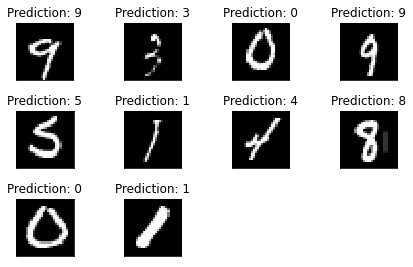

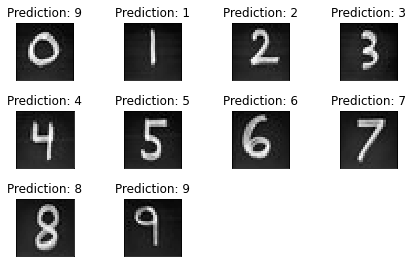

In [7]:
if __name__== "__main__":
    main()